In [1]:
import pandas as pd
import numpy as np

from keras import Input
from keras.engine import Model
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Concatenate, concatenate
from keras.layers import TimeDistributed
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:

# features is a list of strings of feature names 

def build_model(features, data_length):
    
    inputs_list = [] 
    for feature_name in features:
        inputs_list.append((Input(shape=(data_length,1), name=feature_name)))
    
    layers = [] 
    for i, input_name in enumerate(inputs_list): 
        layers.append(LSTM(64, return_sequences=False)(inputs_list[i]) )
        
    output = concatenate(layers) 
    output = Dense(3, activation='softmax', name='IsSpike')(output)
    
    model = Model(
        inputs = inputs_list,
        outputs = [output]
    )
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model    

data_length = 12


### Model Shape

* Price  ----------> LSTM --\
* Google Trends ---> LSTM ---> Dense Layer -> Softmax -> Output: Is Spike (1,0,-1) 
* Volume ----------> LSTM --/




* Input: Price, Google Trends, and Volume for time t0-t9 (10 hours of data) 
* Output: Is Spike (1,0,-1) for t10 
    * Using 10 hours (t0-t9) of Price, Google Trends, and Volume to predict the price movement at t11 (t10)

In [3]:
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('C:/Users/Shoya/surf/data/master_df_v3.csv', encoding='latin1')
df = master_df[['Timestamp', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Date(UTC)', 'Bitcoin (Adj.Overlap)', 
               'Close Price % Change', 'Close Price % Change (Abs)', 'Is Spike']]

# lag inputs depending on data_length 
df['Price_lagged'] = df['Close']#.shift(data_length)
df['Volume_BTC'] = df['Volume_(BTC)']#.shift(data_length)
df['Bitcoin_Adj'] = df['Bitcoin (Adj.Overlap)']#.shift(data_length)

df = df.dropna()
cols = ['Volume_BTC','Bitcoin_Adj', 'Close', 'Price_lagged']

# Stationalize Data by taking log differences
data_array = np.diff(np.log(df[cols]), axis=0)

# Min-Max Scale 

scalers = {}
datas = [] 

df_scaled = pd.DataFrame(columns=cols)


############################################################
#  Fix below - I am scaling the whole data set together, when I should scale the train and test datasets separately
############################################################

for i in range(len(cols)): 
    scalers[cols[i]] = MinMaxScaler()
    #print('data', data_array[:,i])
    
    col_data = data_array[:,i]
    col_data = np.reshape(col_data, (len(col_data), 1))
    
    data = scalers[cols[i]].fit_transform( col_data )
    #print('scaled', data)
    data = np.reshape(data, (1, len(data)))
    df_scaled[cols[i]] = data[0]
    
df_scaled['Is Spike'] = df['Is Spike']
df_scaled.dropna(inplace=True)
display(df_scaled.head())
display(df_scaled.tail())

C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,Is Spike
1,0.776791,0.471970,0.484557,0.484557,1.0
2,0.463316,0.439996,0.538331,0.538331,1.0
3,0.725079,0.529463,0.520715,0.520715,-1.0
4,0.210661,0.416611,0.566098,0.566098,0.0
5,0.594148,0.445509,0.568881,0.568881,-1.0


,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,Is Spike
30285,0.455905,0.449846,0.546519,0.546519,1.0
30286,0.308749,0.457405,0.549938,0.549938,-1.0
30287,0.632915,0.453625,0.563428,0.563428,0.0
30288,0.629822,0.434124,0.506657,0.506657,0.0
30289,0.564642,0.445374,0.493535,0.493535,-1.0


In [4]:
from keras.utils.np_utils import to_categorical

# split and reshape data to feed into RNN

# X_timestamp = df_scaled['Timestamp'].values
X_volume = df_scaled['Volume_BTC'].values
X_trends = df_scaled['Bitcoin_Adj'].values
X_lagged_price = df_scaled['Price_lagged'].values

Y_is_spike = df_scaled['Is Spike'].values 

# train_size = int(len(X_volume) * 0.80)
# train_size = int(train_size/data_length) * data_length

test_size_index = int(len(X_volume)/data_length)*data_length

train_size = int(len(X_volume) * 0.80)
train_size = int(train_size/data_length) * data_length

# train_size = int(len(X_volume) * 0.90)
# train_size = int(train_size/data_length) * data_length

# val_size = int(train_size * 0.95)
# val_size = int(val_size/data_length) * data_length

#print(val_size, train_size, len(X_volume))

X_train_volume = []
X_test_volume = [] 
X_train_trends = []
X_test_trends = []
X_train_lagged_price = []
X_test_lagged_price = []
Y_train_is_spike = [] 
Y_test_is_spike = [] 

for i in range(train_size-data_length):
    vol_temp = []
    trends_temp = []
    price_temp = []
    for j in range(data_length):
        vol_temp.append(X_volume[i+j])
        trends_temp.append(X_trends[i+j])
        price_temp.append(X_lagged_price[i+j])
    X_train_volume.append(vol_temp)
    X_train_trends.append(trends_temp)
    X_train_lagged_price.append(price_temp)
    
    Y_train_is_spike.append(Y_is_spike[i+data_length])

for i in range(test_size_index-train_size-data_length):
    vol_temp = []
    trends_temp = [] 
    price_temp = [] 
    for j in range(data_length):
        vol_temp.append(X_volume[train_size+i+j])
        trends_temp.append(X_trends[train_size+i+j])
        price_temp.append(X_lagged_price[train_size+i+j])
    X_test_volume.append(vol_temp)
    X_test_trends.append(trends_temp)
    X_test_lagged_price.append(price_temp)
    
    Y_test_is_spike.append(Y_is_spike[train_size+i+data_length])
    
X_train_volume = np.array(X_train_volume)
X_test_volume =  np.array(X_test_volume)
X_train_trends = np.array(X_train_trends)
X_test_trends = np.array(X_test_trends)
X_train_lagged_price = np.array(X_train_lagged_price)
X_test_lagged_price = np.array(X_test_lagged_price)
Y_train_is_spike =  np.array(Y_train_is_spike)
Y_test_is_spike = np.array(Y_test_is_spike)
    
    
Y_train_is_spike_onehot = to_categorical(Y_train_is_spike, num_classes=3)
Y_test_is_spike_onehot = to_categorical(Y_test_is_spike,num_classes=3)
display(Y_train_is_spike)

X_train_volume = np.reshape(X_train_volume, (X_train_volume.shape[0],data_length,1) ) 
X_train_trends = np.reshape(X_train_trends, (X_train_trends.shape[0],data_length,1) ) 
X_train_lagged_price = np.reshape(X_train_lagged_price, (X_train_lagged_price.shape[0], data_length, 1))

X_test_volume = np.reshape(X_test_volume, (X_test_volume.shape[0],data_length,1) ) 
X_test_trends = np.reshape(X_test_trends, (X_test_trends.shape[0],data_length,1) )  
X_test_lagged_price = np.reshape(X_test_lagged_price, (X_test_lagged_price.shape[0],data_length,1))

# split training into train and val 


# val_size = int(len(X_train_volume) * 0.80)
# val_size = int(val_size/data_length) * data_length

# X_train_volume, X_val_volume = X_train_volume[:val_size], X_train_volume[-(train_size-val_size):]
# X_train_trends, X_val_trends = X_train_trends[:val_size], X_train_trends[-(train_size-val_size):]
# X_train_lagged_price, X_val_lagged_price = X_train_lagged_price[:val_size], X_train_lagged_price[-(train_size-val_size):]
# Y_train_is_spike_onehot, Y_val_is_spike_onehot = Y_train_is_spike_onehot[:val_size], Y_train_is_spike_onehot[-(train_size-val_size):]




array([ 0.,  0., -1., ...,  1.,  1., -1.])

In [5]:
#features = ['Volume_BTC', 'Bitcoin_Adj', 'Price_lagged']
features = ['Volume_BTC', 'Price_lagged']

rnn = build_model(features, data_length) 

tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history = rnn.fit(
    [
        #X_train_timestamp,
        X_train_volume,
        #X_train_trends,
        X_train_lagged_price
    ],
    [
        Y_train_is_spike_onehot
    ]
    ,
#     validation_data=(
#         [
#             #X_val_timestamp,
#             X_val_volume,
#             #X_val_trends,
#             X_val_lagged_price
#         ],
#         [
#             Y_val_is_spike_onehot
#         ]),
    epochs=25,
    batch_size=64,
    callbacks=[
      tensorboard_callback
    ],
    verbose=1
)

Epoch 1/25
24204/24204 [==============================] - 25s - loss: 1.0764 - categorical_accuracy: 0.4377     ETA: 0s - loss: 1.0762 
Epoch 2/25
24204/24204 [==============================] - 24s - loss: 1.0754 - categorical_accuracy: 0.4383    
Epoch 3/25
24204/24204 [==============================] - 25s - loss: 1.0742 - categorical_accuracy: 0.4383     ETA: 1s - loss:
Epoch 4/25
24204/24204 [==============================] - 24s - loss: 1.0705 - categorical_accuracy: 0.4394    
Epoch 5/25
24204/24204 [==============================] - 23s - loss: 1.0631 - categorical_accuracy: 0.4463    
Epoch 6/25
24204/24204 [==============================] - 34s - loss: 1.0569 - categorical_accuracy: 0.4553    
Epoch 7/25
24204/24204 [==============================] - 42s - loss: 1.0496 - categorical_accuracy: 0.4705    
Epoch 8/25
24204/24204 [==============================] - 43s - loss: 1.0400 - categorical_accuracy: 0.4842    
Epoch 9/25
24204/24204 [==============================] - 42s - 

In [16]:
print(X_train_lagged_price)

[[[ 0.48455698]
  [ 0.53833093]
  [ 0.52071465]
  ..., 
  [ 0.54545996]
  [ 0.55096198]
  [ 0.54872932]]

 [[ 0.53833093]
  [ 0.52071465]
  [ 0.56609793]
  ..., 
  [ 0.55096198]
  [ 0.54872932]
  [ 0.51486794]]

 [[ 0.52071465]
  [ 0.56609793]
  [ 0.56888114]
  ..., 
  [ 0.54872932]
  [ 0.51486794]
  [ 0.5310675 ]]

 ..., 
 [[ 0.52719619]
  [ 0.57096377]
  [ 0.55465854]
  ..., 
  [ 0.52102749]
  [ 0.54993302]
  [ 0.54559069]]

 [[ 0.57096377]
  [ 0.55465854]
  [ 0.52039286]
  ..., 
  [ 0.54993302]
  [ 0.54559069]
  [ 0.51424227]]

 [[ 0.55465854]
  [ 0.52039286]
  [ 0.52730497]
  ..., 
  [ 0.54559069]
  [ 0.51424227]
  [ 0.5760172 ]]]


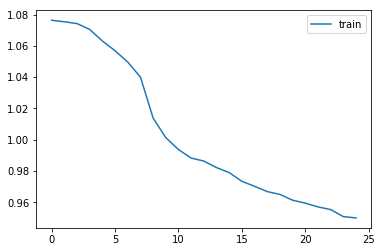

In [6]:
from matplotlib import pyplot as plt

# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [7]:
score = rnn.evaluate(
    [
        #X_test_timestamp,
        X_test_volume,
        #X_test_trends,
        X_test_lagged_price
    ],
    [
        Y_test_is_spike_onehot
    ])

print('\n')
print("Accuracy: %.2f%%" % (score[1]*100))

6048/6048 [==============================] - 2s     


Accuracy: 50.64%


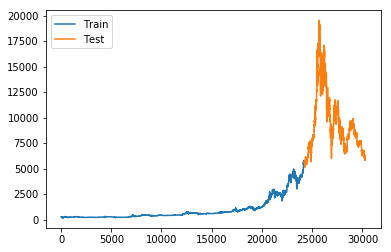

In [8]:
train_size = int(len(X_volume) * 0.8)
train_size = int(train_size/data_length) * data_length

# val_size = int(train_size * 0.95)
# val_size = int(val_size/data_length) * data_length

plt.plot(df['Close'].iloc[:train_size], label='Train')
#plt.plot(df['Close'].iloc[val_size:train_size], label='Validation')
plt.plot(df['Close'].iloc[train_size:], label='Test')
plt.legend()
plt.show();

# TODO: maybe move around so that validation is a little before peak to 24000 ish and test is a little before peak to end 

### To test if Google Trends actually have any benefit in predicting spikes, I ran one with and without the trend data as input. 

#### For "Is Spike" cutoff of 0.1, (meaning Is Spike marks only the 10% biggest changes)
    * With trend data, accuracy was 78.90% on test data.
    * Without trend data, accuracy was 82.93% on test data.
    
#### For "Is Spike" cutoff of 0.3, 
    * With trend data, accuracy was 84.57% for epoch=40 and 89.69% for epoch=60, 87.98% for epoch=100, and 92.02% for epoch=200
    * Without trend data, accuracy was 78.40% for epoch=40 and 88.88% for epoch=60, 93.60% for epoch=100, and 90.14% for epoch=200
    
    
    * Accuracy on test data is much better than that of train data 
        * -> could be because the test data is statistically different than train data 
            * which makese sense because test data is the real big spike 
                    * Since I am using 10 hours of data to predict the next hour, it would make sense that the accuracy is good during this time since this is the time that people were looking up Bitcoin and perhaps buying them a few hours later 
                * get more up-to-date data 
        * OR BECAUSE TRAIN AND TEST DATA SOMEHOW OVERLAPS?
        
#### With updated data
    * With trend data, accuracy was 45.12% for epoch=100, 45.56% for epoch=200 -> overfitting?
        * -> put in dropout 
    - Without trend data, accuracy was 43.11% for epoch=100, 43.97% for epoch=200
    
    * with the updated data, the test data is now from December 20th, which is right after the massive spike already happened, to June
    * Before, test data used to be from start of October to April-ish
    
#### With Updated Data and with Dropout of 0.2 
    * With trend data, accuracy was 38.61% for epoch=150
    * Without trend data, accuracy was 38.87% for epoch=150
    
    TODO: Increase data_length (memory in LSTM) and change dropout 
    
#### Data_length=12 with Dropout of 0.2 
    * With trend data, accuracy was 38.44% for epoch=400
    * Without trend data, accuracy was 31.90% for epoch=400
    
#### Increasing data_length to 20 (with dropout)
    * With trend data, accuracy was 38.23% with epoch=150
    
#### Data_length of 20 without dropout 
    * With trend data, accuracy was 46.90% with epoch=100
    * Without trend data, accuracy was 46.13% with epoch=100
    
#### Data_length of 24 without dropout
    * With trend data, accuracy was 44.17% with epoch=200
    
#### Data_length of 35 without dropout
    * With trend data, accuracy was 46.8% with epoch=100
    * Without trend data, accuracy was 43.52% with epoch=100
    
#### Data_length of 50 without dropout 
    * With trend data, accuracy was 45.40% with epoch=100
    * Without trend data, accuracy was 45.67% with epoch=100
    
### After introducing validation data and changing training to be 80% instead of 85% 
    
#### Data_length of 12 with dropout=0.2 
    * With trend data, accuracy was 37.40% for epoch = 25, 37.95% for epoch=200
    * Without trend data, accuracy was 36.94% for epoch=25 X% for epoch=200
        * -> Overfit way too much and the validation loss was actually increasing a lot 
            * -> that's probably what's been happening for all

### After moving around train/validation/train 
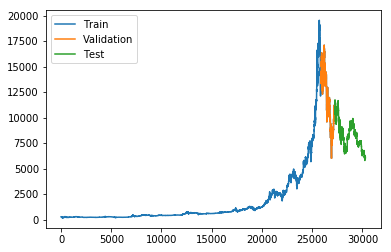 24516 27252 30284

#### Data_length of 12 with dropout=0.2 
    * With trend data, accuracy was 34.69% for epoch=100 
    * Without trend data, accuracy was 33.86% for epoch=100
  
    
### After moving around train/validation/train again 
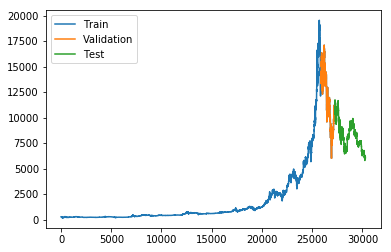 25884 27252 30284

#### Data_length of 12 with dropout=0.2
   * With trend data, accuracy was 34.79% for epoch=100 
   * Without trend data, accuracy was 34.73% for epoch=100
    
#### data_length of 12 without dropout
    * With trend data, accuracy was 37.38% for epoch=30, 31.97% for epoch=100
    * Without trend data, accuracy was 35.86% for epoch=30, 32.34% for epoch=100
    
### Getting rid of Validation data and going back to 90/10 train/test split

#### Data_length of 12 without dropout
    * With trend data, accuracy was 42.43% for epoch=10, 43.63% for epoch=20, 38.68% for epoch=35, 32.34% for epoch=100
    * Without trend data, accuracy was 43.59% for epoch=10, 44.85% for epoch=20, 34.13% for epoch=35, 32.70% for epoch=100
    
### With 80/20 train/test split

### Data_length of 12 without dropout 
    * With trend data for "bitcoin", accuracy was 48.51% for epoch=25, 56.60% for epoch=100, 54.50% for epoch=200
    * With trend data for "Coinbase", accuracy was 51.01% for epoch=30, 55% for epoch=100
    * Without trend data, accuracy was 52.41% for epoch=25, 57.21% for epoch=100, 53.64% for epoch=200
 
### Data_length of 60 without dropout
    * With trend data for "Coinbase", accuracy was 51.21% for epoch=50
    
    
    *Todo: graph the test data and change colors depending on if value was predicted correctly or not!!!!!!!!!
    *Todo: graph train, validate, and test
        * -> The train data is not at all indicative of test data!!
    * Todo: I could add in many more keyword inputs to the network and see if any improves performance (Bitstamp, Coinbase, Ethereum, How to buy Bitcoin, Bitcoin bubble, etc) 
    
    * TODO: maybe move around so that validation is a little before peak to 24000 ish and test is a little before peak to end 
        Or just train until bitcoin price fall then test on the final little bit 
        
    * TODO: feed in other Google Trends to see if anything helps!!!!!!!!!!!!!!!!!!!

In [9]:
yhat = rnn.predict( 
    [
        #X_test_timestamp,
        X_test_volume,
        #X_test_trends,
        X_test_lagged_price
    ],
    verbose=0
)

display(yhat)

inverted_yhat = np.argmax(yhat,axis=1) #returns INDICES of max 
onehot_to_val_dict = {0: 0, 1: 1, 2:-1 }

inverted_yhat_arr = np.asarray(inverted_yhat)
predicted = [onehot_to_val_dict[i] for i in inverted_yhat_arr]


df_pred_output = pd.DataFrame(predicted, columns=['predicted'])
df_pred_output['actual'] = Y_test_is_spike
#df_pred_output['index_output'] = inverted_yhat
display(df_pred_output.head())

correct = (df_pred_output['actual'].values == df_pred_output['predicted'].values)
accuracy = correct.sum() / correct.size
display(accuracy)

array([[ 0.16194554,  0.04181287,  0.79624158],
       [ 0.30329648,  0.66782153,  0.02888208],
       [ 0.01333533,  0.9773826 ,  0.00928201],
       ..., 
       [ 0.08155957,  0.00180359,  0.91663677],
       [ 0.75920671,  0.20132808,  0.0394652 ],
       [ 0.03704861,  0.06864651,  0.89430481]], dtype=float32)

,predicted,actual
0,-1,-1.0
1,1,0.0
2,1,1.0
3,1,1.0
4,-1,-1.0


0.53637566137566139

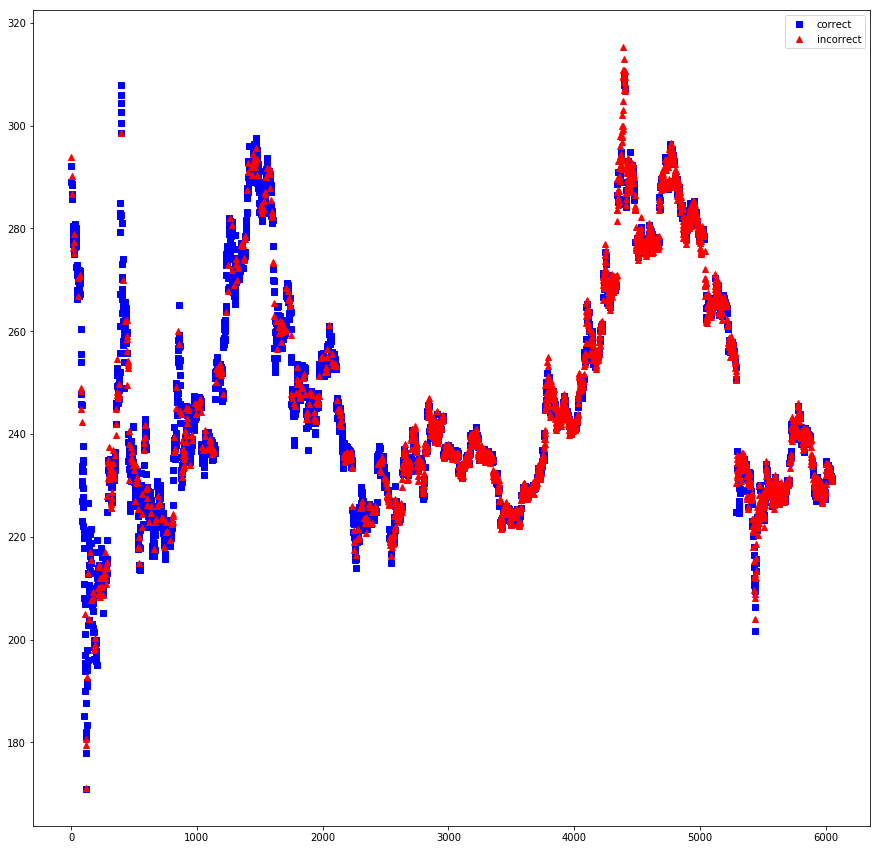

In [10]:
correct = (df_pred_output['actual'].values == df_pred_output['predicted'].values)
incorrect = (df_pred_output['actual'].values != df_pred_output['predicted'].values)

fig, ax = plt.subplots(figsize=(15,15))

ax.plot(df.loc[correct, "Close"], 'bs', label='correct', )
ax.plot(df.loc[incorrect, "Close"], 'r^', label='incorrect', )
plt.legend()
plt.show();

In [31]:
# serialize model to JSON# serial 
model_json = rnn.to_json()
with open("model_classification_v1data_200epochs_10length.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
rnn.save_weights("model_classification_v1data_200epochs_10length.h5")

In [21]:
from sklearn import metrics

#print(metrics.confusion_matrix(df_pred_output['actual'].values, df_pred_output['predicted'].values,labels=[0,1,-1]))

confusion_matrix = pd.crosstab(df_pred_output['actual'].values, df_pred_output['predicted'].values, rownames=['Actual'], colnames=['Predicted'], margins=True)

display(confusion_matrix)

Predicted,-1,0,1,All
Actual,,,,
-1.0,808,298,628,1734
0.0,333,476,382,1191
1.0,500,345,760,1605
All,1641,1119,1770,4530


In [40]:
# need to check what the rnn actually learned 
# visualize predicted vs actual to get insight into this 

# try with instead of just 10% biggest changes, maybe with 25% 
# is it just learning from the previous prices, or is google trends actually helping 
# -> run rnn without google trends 


# I have a master_df_v2 now so try that - this one has 0.3 as cutoff for is Spike 
# Have to eventually get validation data - also get overall newer more data 